<a href="https://colab.research.google.com/github/kookeej/AI-study/blob/main/RNN/time_series_forecasting_with_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time Series Forecasting with LSTM
===
*reference: https://www.youtube.com/watch?v=RC7oiddQlEg*


> ### 시계열이 일반 회귀 문제와 다른 점은 무엇일까?
>1. `시간 의존적`: 예측값이 독립적이라는 선형 회귀 모델의 기본 가정이 적용되지 않는다.
>2. `계절성 추세`: 특정 기간에 따른 변형   

>### RNN의 문제점
>1. Gradient vanishing
>2. Gradient exploding

>### 해결 방법
>1. LSTM
>2. GRU
>3. BERT

In [4]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# seaborn library에 있는 모든 데이터셋의 이름을 출력
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [6]:
# 항공 데이터셋 load
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


3개의 feature가 존재한다.

In [7]:
flight_data.shape

(144, 3)

144개의 데이터가 존재하고 3개의 feature를 가진다. 즉, 144개월간의 기록이 있다.    
우리는 여기서 132개월을 lstm 학습에 사용하고 남은 12개월 데이터로 성능을 평가한다.

In [11]:
fig_size = plt.rcParams['figure.figsize'] = (15, 5)       # rcParams를 통해 차트 그림 기본설정을 할 수 있다.
# fig_size[0] = 15
# fig_size[1] = 5
plt.rcParams['figure.figsize'] = fig_size

rcParams에서 자주 사용하는 값들은 아래와 같다.    

|속성|설명|
|:----:|------------|
|**figure.figsize**|그림(figure)의 크기. (width, height)의 인치 단위|
|**lines.linewidth**|선의 두께|
|**lines.color**|선의 색깔|
|**axes.grid**|차트 내 grid 표시 여부|

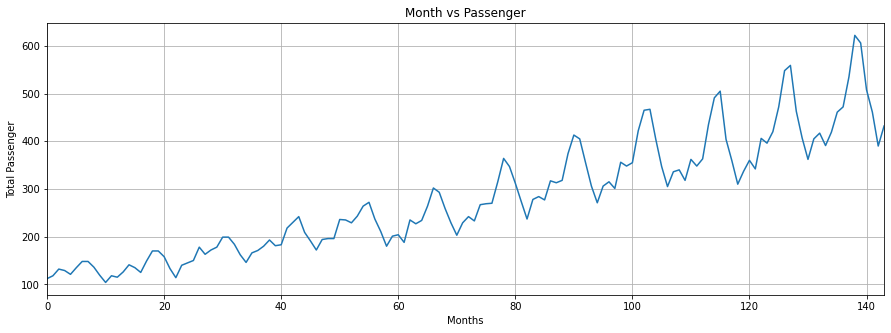

In [13]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passenger')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])

In [20]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [16]:
# 승객의 열 유형을 부동 소수점으로 변경(원래는 int64)
all_data = flight_data['passengers'].values.astype(float)

In [22]:
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


이제 데이터셋을 train/test set으로 나눈다. 모델은 lstm 알고리즘을 사용한다. 

In [47]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(all_data, test_size=1/12, shuffle=False)

In [48]:
print(len(train_data))
print(len(test_data))

132
12


In [49]:
print(test_data)

[417. 391. 419. 461. 472. 535. 622. 606. 508. 461. 390. 432.]


현재 데이터셋은 정규화되어있지 않다. 초기 항공 승객은 후기 승객수보다 매우 적다. 따라서 시계열 예측을 위해 데이터를 정규화하는 것은 매우 중요하다.

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))        # -1과 1사이로 정규화
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [51]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


결과를 확인해보면 -1에서 1사이 값으로 정규화가 진행되었음을 확인할 수 있다. 이 정규화는 오직 train set에만 적용된다.    
만약 test set을 정규화시키면 일부 정부가 train set으로 유출될 가능성이 있다. (?????????왠지 모름)

이번에는 데이터셋을 텐서로 변환한다. 

In [52]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [53]:
train_window = 12

In [54]:
# in-out 순서 생성
def create_inout_sequence(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]      # train set 1-132까지의 데이터 하나
        train_label = input_data[i+tw:i+tw+1]   # test set 133-144까지의 데이터 하나
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [55]:
train_inout_seq = create_inout_sequence(train_data_normalized, train_window)

In [56]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]

이제 LSTM 모델을 설계한다.

In [81]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_size),
                            torch.zeros(1, 1, self.hidden_size))
        # super().__init__()
        # self.input_size = input_size
        # self.hidden_size = hidden_size

        # self.lstm = nn.LSTM(
        #     input_size = input_size,
        #     hidden_size = hidden_size,
        #     num_layers = 4,
        #     bidirectional = True
        # )
        # self.layers = nn.Sequential(
        #     nn.ReLU(),
        #     nn.Linear(input_size*2, hidden_size)
        # )

        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        prediction = self.linear(lstm_out.view(len(input_seq), -1))
        return prediction[-1]
        # y, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        # y = self.layers(y)
        # return y

In [82]:
# LSTM 객체 생성
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [83]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [84]:
# 모델 학습
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),
                            torch.zeros(1, 1, model.hidden_size))
        
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00970320
epoch:  26 loss: 0.00871714
epoch:  51 loss: 0.01069154
epoch:  76 loss: 0.00008625
epoch: 101 loss: 0.00705828
epoch: 126 loss: 0.00356397
epoch: 149 loss: 0.0276421960


In [85]:
fut_pred = 12           # 미래 예측
test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [86]:
# 검증
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        test_inputs.append(model(seq).item())

In [87]:
# 정규화된 값이 나온다.
test_inputs[fut_pred:]

[0.4825625717639923,
 0.3660377562046051,
 0.28855961561203003,
 0.5140975117683411,
 0.462953120470047,
 0.6697899699211121,
 0.5724673867225647,
 0.9048423171043396,
 0.48223257064819336,
 0.9979586005210876,
 0.5485185384750366,
 1.0791429281234741]

In [88]:
# 실제값으로 변경해본다.
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
print(actual_predictions)

[[441.28298508]
 [414.77358954]
 [397.14731255]
 [448.45718393]
 [436.82183491]
 [483.87721816]
 [461.73633048]
 [537.35162714]
 [441.20790982]
 [558.53558162]
 [456.2879675 ]
 [577.00501615]]


In [89]:
# 실제 변수에 대해 예측
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


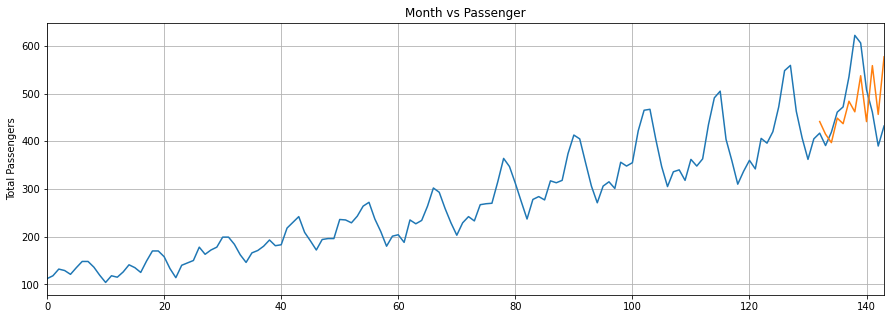

In [90]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x, actual_predictions)
plt.show()

주황색 선에 해당하는 값이 lstm 예측값이다.    

아주 정확하진 않지만 위쪽에 위치하는 것을 확인할 수 있다.     

정확도를 높이기 위해서는 레이어에 더 많은 수의 뉴런을 넣고 더 많은 epoch에서 학습을 시도할 수 있다.

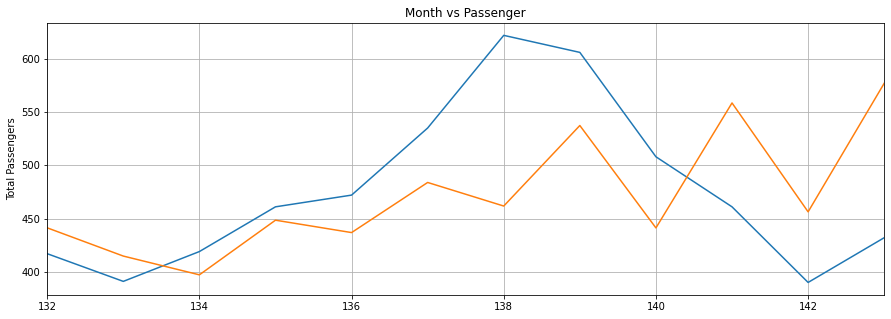

In [91]:
# 12개월동안의 출력
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x, actual_predictions)
plt.show()

예측 잘 못한 것 같음